In [1]:
# pip install rouge-score
# pip install evaluate
# pip install bert-score

In [2]:
import nltk
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate import meteor

from rouge_score import rouge_scorer
from transformers import BartTokenizer, BartForConditionalGeneration, BartModel
import evaluate

import torch
import json
import random
import numpy as np

2024-07-12 15:43:47.986433: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 15:43:48.014265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 15:43:48.014288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 15:43:48.015074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 15:43:48.019770: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Download necessary NLTK data
# nltk.download('punkt')

## Data Collection

In [4]:
# per conversation list, each item is an utterance
# the 1st utterance should have higher score than the second

# one prediction vs multiple references, pick the highest score
ref_lss = [
        ["The cat is on the mat","There is a cat on the mat", "That is a cat on the tree"],
        ["I don't know what to say", "There is a dog barking", "There is a cat meowing"]
    ] 
cad_ls = [
        "The cat is on the mat", #1st higher
        "A dog is barking"
    ]

## Evaluation

### Calculate BLEU

In [5]:

def calculate_bleu(reference_texts, hypothesis_text, ngram_order=4, smoothing=True, highest_score=True):
    """
    Calculate BLEU scores for a single hypothesis text against multiple reference texts.
    
    Parameters:
    - reference_texts: List of reference texts (either a list of strings or a list of lists of strings).
    - hypothesis_text: Single hypothesis text (string).
    - ngram_order: Maximum n-gram order to use for BLEU calculation.
    - smoothing: Whether to apply smoothing.
    - highest_score: True to calculate the highest score, False to calculate the average score.
    
    Returns:
    - bleu_scores: List of BLEU scores (highest or average) for each set of reference texts.
    """
    smooth_fn = SmoothingFunction().method1 if smoothing else None
    weights = tuple((1.0 / ngram_order) for _ in range(ngram_order))
    
    hypothesis_tokens = hypothesis_text.split()


    scores = []
    for ref in reference_texts:
        ref_tokens = ref.split()
        score = sentence_bleu([ref_tokens], hypothesis_tokens, weights=weights, smoothing_function=smooth_fn)
        scores.append(score)
        
    if highest_score:
        highest_bleu_score = max(scores)
        bleu_scores=round(highest_bleu_score, 4)
    else:
        average_bleu_score = sum(scores) / len(scores)
        bleu_scores=round(average_bleu_score, 4)
    
    return bleu_scores

# highest
bleu_cad_h = []
for cad, ref_ls in zip(cad_ls, ref_lss):
    bleu_cad_h.append(calculate_bleu(ref_ls, cad))
    
print(bleu_cad_h)
print("Highest BLEU scores:", bleu_cad_h)

# average
bleu_cad_a = []
for cad, ref_ls in zip(cad_ls, ref_lss):
    bleu_cad_a.append(calculate_bleu(ref_ls, cad, highest_score=False))
    
print(bleu_cad_a)
print("Average BLEU scores:", bleu_cad_a)



[1.0, 0.0823]
Highest BLEU scores: [1.0, 0.0823]
[0.4271, 0.0483]
Average BLEU scores: [0.4271, 0.0483]


### Calculate ROUGE 

In [6]:

def cal_rouge_score(reference_list, candidate, ngram_order=['rouge1', 'rouge2', 'rougeL'], highest_score=True):
    """
    Calculate ROUGE score (f-measure) of candidate (highest or average) against each reference in the reference list.
   
    
    Parameters:
    - reference_list: List of reference texts.
    - candidate: Candidate text to compare against reference texts.
    - ngram_order: List of n-grams to use for ROUGE calculation.
    - highest_score: True to calculate the highest score, False to calculate the average score.
    
    Returns:
    - score_dict: Dictionary containing ROUGE scores for each n-gram order.
    """
    
    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(ngram_order, use_stemmer=True)


    # Initialize score dicts
    score_dicts = {ngram:[] for ngram in ngram_order}

    # Calculate ROUGE 
    for ref in reference_list:
        scores = scorer.score(ref, candidate)

        for n_gram in ngram_order:
            score_dicts[n_gram].append(scores[n_gram].fmeasure)
            
        
    # final score depending on highest/mean
    final_dict = {}

    for n_gram, score in score_dicts.items():
        
        if highest_score:
            final_dict[n_gram] = round(np.max(score), 4)
        else:
            final_dict[n_gram] = round(np.mean(score), 4)


    return final_dict



rouge_cad = []
for cad, ref_ls in zip(cad_ls, ref_lss):
    rouge_cad.append(cal_rouge_score(ref_ls, cad))
# print(rouge_cad)

# check matching
if len(rouge_cad) == len(cad_ls):
    print(f"rouge score of each utterance is {rouge_cad}")
else:
    print("the numeber of score and utter not matched")



rouge score of each utterance is [{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0}, {'rouge1': 0.8889, 'rouge2': 0.2857, 'rougeL': 0.6667}]


## Calculate Meteor Score

In [7]:
def cal_meteor(ref_ls, cad, highest_score=True):
    """
    calculate meteor score

    Para:
    - ref_ls: reference list of utterances
    - cad: candidate/prediction string
    - highest_score: True to calculate the highest score, False to calculate the average score.

    Return:
    highest or average score
    """

    scores=[]
    for ref in ref_ls:
        score = round(meteor([word_tokenize(ref)], word_tokenize(cad)), 4)
        scores.append(score)
        # print(score)

    if highest_score:
        final_score=np.max(scores)
    else:
        final_score=np.mean(scores)

    return final_score

scores=[]
for cad, ref_ls in zip(cad_ls, ref_lss):

    scores.append(cal_meteor(ref_ls, cad))
    
# check matching
if len(scores) == len(cad_ls):
    print(f"meteor score of each utterance is {scores}")
else:
    print("the numeber of score and utter not matched")    

meteor score of each utterance is [0.9977, 0.6441]


## Calculate Bert-score

In [9]:

def cal_bert(reference_sentences, candidate_sentence, lang="en", highest_score=True):
    """
    Calculate BERTScore for a single candidate sentence against multiple reference sentences.
    
    Parameters:
    - reference_sentences: List of reference sentences.
    - candidate_sentence: Single candidate sentence.
    - lang: Language of the sentences.
    - highest_score: True to return the highest score, False to return the average score.
    
    Returns:
    - bert_scores: Dictionary containing BERTScore Precision, Recall, and F1 (highest or average).
    """
    # Create a list of the candidate sentence repeated for each reference sentence
    candidate_sentences = [candidate_sentence] * len(reference_sentences)
    
    # Calculate BERTScore
    P, R, F1 = score(candidate_sentences, reference_sentences, lang=lang, verbose=True)
    
    if highest_score:
        # Calculate and return the highest BERTScore metrics
        bert_scores = {
            "Precision": round(P.max().item(), 4),
            "Recall": round(R.max().item(), 4),
            "F1": round(F1.max().item(), 4)
        }
    else:
        # Calculate and return the mean BERTScore metrics
        bert_scores = {
            "Precision": round(P.mean().item(), 4),
            "Recall": round(R.mean().item(), 4),
            "F1": round(F1.mean().item(), 4)
        }
    
    return bert_scores




bert_cad = []
for cad, ref_ls in zip(cad_ls, ref_lss):
    bert_scores = cal_bert(ref_ls, cad)
    bert_cad.append(bert_scores)
print(bert_cad)

# check matching
if len(bert_cad) == len(cad_ls):
    print(f"rouge score of each utterance is {bert_cad}")
else:
    print("the numeber of score and utter not matched")


NameError: name 'score' is not defined

## Evaluation_all conversations

In [10]:
# multiple converstaions
ref_lss = [
        [
            ["The cat is not on the mat","There is a cat on the mat", "That is a cat on the tree"], #ref list of 1st utterance
            ["I don't know what to say", "There is a dog barking", "There is a cat meowing"]
        ],#1 conver
        [
            ["A quick brown fox jumps over a lazy dog.","The quick brown fox leaped over the lazy dog.","A fast brown fox jumps over a sleepy dog."],
            ["I don't know what to say", "There is a dog barking", "There is a cat meowing"],
            ["I don't know what to say"]
        ]#2 conver
    ] 
cad_ls = [
        ["The cat is on the mat", #1st utterance
        "A dog is barking"], #1 conver
        ["The quick brown fox jumps over the lazy dog.",
         "The lazy dog cried because of that",
         "What to say"] #2 conver
    ]

# check num of cad and ref groups
if len(ref_lss) == len(cad_ls):
    print("num of cad matches ref groups")
else:
    print("num of cad not matches ref groups")
    
# check num of utter of cad and ref num per ref group
for n,cad in enumerate(cad_ls):
    print(len(cad), len(ref_lss[n]))
    if len(cad) == len(ref_lss[n]):
        print(f"utter num of {n}th cad matches ref num of the group")
    else:
        print(f"utter num of {n}th cad not matches ref num of the group")

num of cad matches ref groups
2 2
utter num of 0th cad matches ref num of the group
3 3
utter num of 1th cad matches ref num of the group


In [18]:

def evaluate_conversations(cad_ls, ref_lss):
    """
    evaluate_conversations scores of bleu, rouge, meteor
    """
    
    scores_all = {str(i): [] for i in range(len(cad_ls))}
    
    for n, cad_l in enumerate(cad_ls):
        cad_l_bleu = []
        cad_l_rouge = []
        cad_l_meteor = []

        for cad, ref_l in zip(cad_l, ref_lss[n]):
            # print(cad, ref_l)
            ngram_bleu = 4
            cad_l_bleu.append(calculate_bleu(ref_l, cad, ngram_order=ngram_bleu, smoothing=True, highest_score=True))
            cad_l_rouge.append(cal_rouge_score(ref_l, cad, highest_score=True))
            cad_l_meteor.append(cal_meteor(ref_l, cad, highest_score=True))
        
        cad_l_rouges = {}
        for dict_scores in cad_l_rouge:
            for k, v in dict_scores.items():
                if k not in cad_l_rouges:
                    cad_l_rouges[k] = [v]
                else:
                    cad_l_rouges[k].append(v)

        scores_all[str(n)] = [
            {f"bleu{ngram_bleu}": round(np.mean(cad_l_bleu),4)},
            {"rouge": {k: round(np.mean(v),4) for k, v in cad_l_rouges.items()}},
            {"meteor": round(np.mean(cad_l_meteor),4)}
        ]

    return scores_all


scores_all = evaluate_conversations(cad_ls, ref_lss)
print(scores_all)


{'0': [{'bleu4': 0.185}, {'rouge': {'rouge1': 0.906, 'rouge2': 0.5065, 'rougeL': 0.7949}}, {'meteor': 0.7488}], '1': [{'bleu4': 0.2394}, {'rouge': {'rouge1': 0.5519, 'rouge2': 0.4167, 'rougeL': 0.5519}}, {'meteor': 0.5139}]}


In [19]:
# scores_all = {
#     '0': [{'bleu': 0.185}, {'rouge': {'rouge1': 0.906, 'rouge2': 0.5065, 'rougeL': 0.7949}}, {'meteor': 0.7488}],
#     '1': [{'bleu': 0.2394}, {'rouge': {'rouge1': 0.5519, 'rouge2': 0.4167, 'rougeL': 0.5519}}, {'meteor': 0.5139}]
# }

ngram_bleu = 4
ngram_rouge = ['rouge1', 'rouge2', 'rougeL']

metrics_names = [f"bleu{ngram_bleu}", "meteor"]
metrics_names.extend(ngram_rouge)
# print(metrics_names)

data = {}

data["Candidate"] = [f"Candidate{name}" for name in scores_all.keys()]
# print(data)

for n in metrics_names:
    data[n] = []

# print(data)

for ls in scores_all.values():
    for metric_dict in ls:
        for k, v in metric_dict.items():
            if k in data:
                data[k].append(v)
            elif isinstance(v, dict):
                for sub_k, sub_v in v.items():
                    if sub_k in data:
                        data[sub_k].append(sub_v)
                    else:
                        data[sub_k] = [sub_v]

print(data)


{'Candidate': ['Candidate0', 'Candidate1'], 'bleu4': [0.185, 0.2394], 'meteor': [0.7488, 0.5139], 'rouge1': [0.906, 0.5519], 'rouge2': [0.5065, 0.4167], 'rougeL': [0.7949, 0.5519]}


## prompt choices

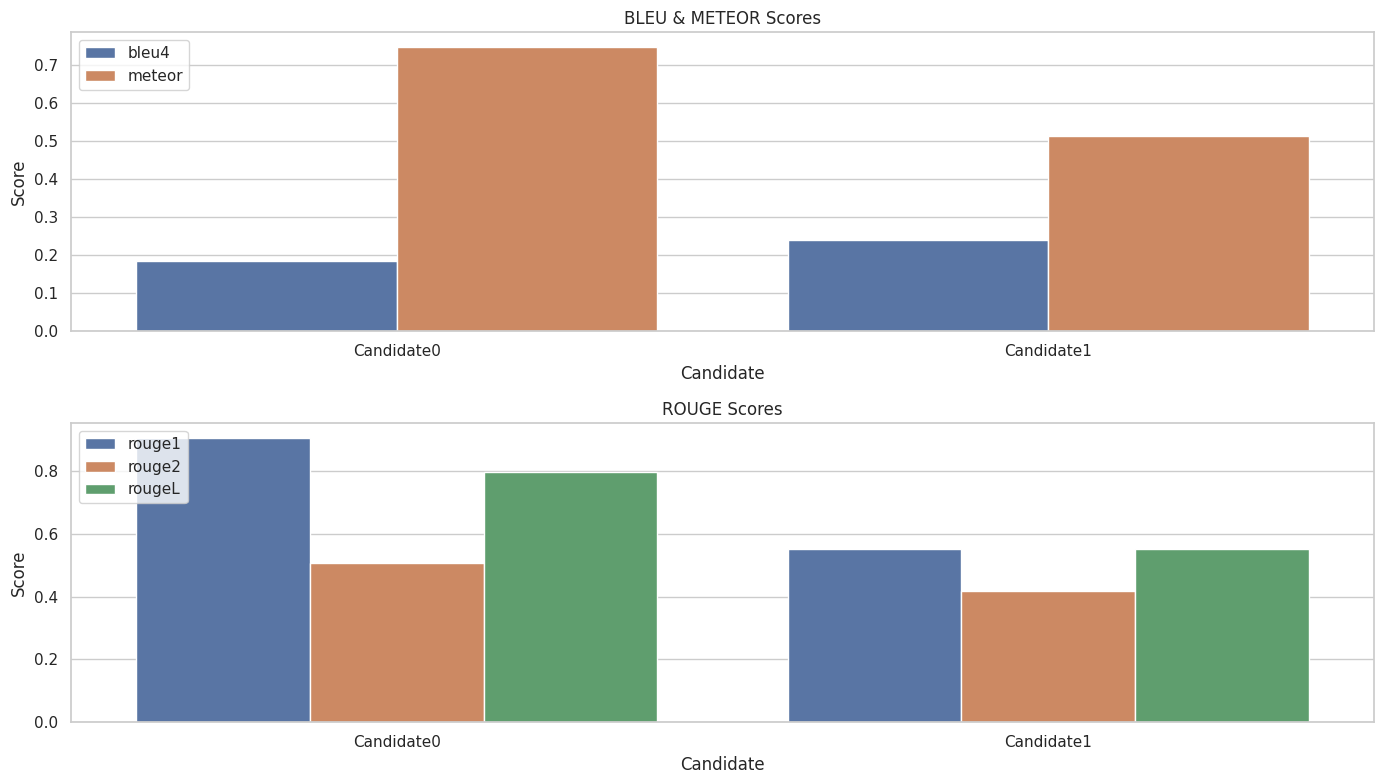

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Create a DataFrame
df = pd.DataFrame(data)

# Set up the seaborn style
sns.set(style="whitegrid")

# Plot BLEU scores
plt.figure(figsize=(14, 8))

# Reshape the DataFrame for plotting
melted_bleu = df.melt(id_vars="Candidate", value_vars=[f"bleu{ngram_bleu}", "meteor"], var_name="Metric", value_name="Score")

# Plot BLEU scores with seaborn
plt.subplot(2, 1, 1)
sns.barplot(x="Candidate", y="Score", hue="Metric", data=melted_bleu)
plt.title('BLEU & METEOR Scores')
plt.ylabel('Score')
plt.legend(loc='upper left')

# # Plot ROUGE scores
# plt.figure(figsize=(14, 8))

# Reshape the DataFrame for plotting
melted_rouge = df.melt(id_vars="Candidate", value_vars=ngram_rouge, var_name="Metric", value_name="Score")

# Plot ROUGE scores with seaborn
plt.subplot(2, 1, 2)
sns.barplot(x="Candidate", y="Score", hue="Metric", data=melted_rouge)
plt.title('ROUGE Scores')
plt.ylabel('Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
